# Trees

<img src="./media/nice_tree.jpg">

# Binary Search Tree

<img src="./media/bstree.jpg">

## YES/NO `questions`

A node asks the following question: `Is the number you're looking for greater than me?`

- Simple questions
- Space partitioning
<img src="./media/kdtree.png">

# Decision Trees
Start with observations, reach a conclusion.
<img src="./media/decision_tree.jpg">

Further reading:
- KD Trees: same concept, generalized to K Dimensions
- K Nearest Neighbors - supervized learning using KD Trees
- K Means - unsupervized learning, used for clustering  

Video introduction to identification trees:
- https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-034-artificial-intelligence-fall-2010/lecture-videos/lecture-11-learning-identification-trees-disorder/

# Regressing using trees - predicting a real number

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [325]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import mean_squared_error, mean_squared_log_error
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
df = pd.read_csv('./data/train.csv')
df.shape

(1460, 81)

## Simplest model - predicting the mean

In [5]:
df.SalePrice.mean()

180921.19589041095

## Adding more information

In [6]:
df[['YrSold', 'SalePrice']].head()

,YrSold,SalePrice
0,2008,208500
1,2007,181500
2,2008,223500
3,2006,140000
4,2008,250000


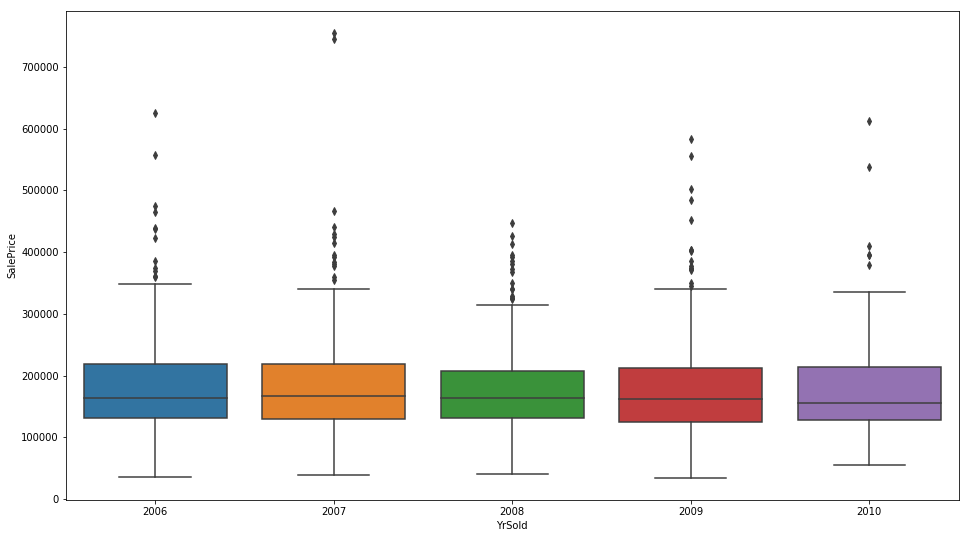

In [10]:
sns.boxplot('YrSold', 'SalePrice', data=df)

## Simplest regression tree

In [13]:
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

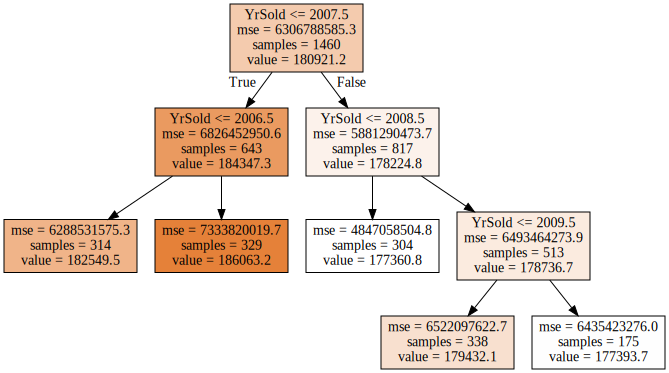

In [296]:
rf = RandomForestRegressor(n_estimators=1, bootstrap=False)
rf.fit(df.YrSold.values.reshape(-1, 1), df.SalePrice)
s = export_graphviz(rf.estimators_[0], feature_names=['YrSold'], out_file='simple.dot', filled=True, precision=True)
path = 'simple.dot'
graphviz.Source.from_file(path)

## Adding another column

In [18]:
rf = RandomForestRegressor(n_estimators=1, bootstrap=False)
rf.fit(df[['YrSold', 'LotArea']], df.SalePrice)
s = export_graphviz(rf.estimators_[0], feature_names=['YrSold', 'LotArea'], out_file='tree.dot', filled=True, precision=True)
path = 'tree.dot'
s = graphviz.Source.from_file(path)
s.view()

'tree.dot.pdf'

## Asking the right questions

\begin{align}
MSE = \frac{\sum{(\text{expected} - \text{predicted})}^2}{\text{number of samples}}
\\
\\
LOSS = \frac{MSE(\text{left}) * len(\text{left}) + MSE(\text{right}) * len(\text{right})}{\text{number of samples}}
\end{align}

In [199]:
chosen_columns = ['YrSold', 'LotArea', 'YearBuilt', 'OverallCond', 'OverallQual']
X_raw = df[chosen_columns].values
Y_raw = df.SalePrice.values

X_train, X_test, Y_train, Y_test = train_test_split(X_raw, Y_raw, test_size=0.2)

# Creating our own tree

## Cost functions

In [23]:
def mse(expected, predicted):
    return np.mean(np.square(expected - predicted))

In [25]:
def loss(left, right):
    return (mse(left, np.mean(left)) * left.size + mse(right, np.mean(right)) * right.size) / (left.size + right.size)

## Training

<img src="./media/rfdepth.png">

In [263]:
def create_tree(X, Y, samples, max_depth=2, min_samples=3, col_proc=0.5, depth=1):
    """
    :param samples: training data
    :param depth: current depth
    :param max_depth: don't go bellow this level
    :param min_samples: make a leaf for fewer samples than this
    :param col_proc: percentage of columns to be used as features
    """
    
    # Default is the mean
    node = dict(value=np.mean(Y[samples]), split=(), samples=len(samples), left=None, right=None)
    
    # Stop if the maximum depth was reached
    if depth > max_depth:
        return node

    # Create a leaf if there are less than min_samples samples in this node
    if len(samples) < min_samples:
        return node
    
    best_cost = None
    best_left = []
    best_right = []
    best_split = ()
    
    # Choose columns
    columns = np.arange(X.shape[1])
    np.random.shuffle(columns)
    columns = columns[:int(X.shape[1] * col_proc)]
    
    # Try each column
    for col in columns:
        values = X[samples, col]
        
        # Try every possible value as a split point
        for split_value in values:
            left = []
            right = []
            
            # Partition samples
            for s in samples:
                if X[s][col] < split_value:
                    left.append(s)
                else:
                    right.append(s)

            if len(left) == 0 or len(right) == 0:
                continue

            # Update best loss
            cost = loss(Y[left], Y[right])
            if best_cost is None or cost < best_cost:
                best_cost = cost
                best_left = left
                best_right = right
                best_split = (split_value, chosen_columns[col])
   
    # Expand subtrees
    if len(best_left) > 0 and len(best_right) > 0:
        node['split'] = best_split
        node['left'] = create_tree(X, Y, best_left, max_depth=max_depth, min_samples=min_samples, col_proc=col_proc, depth=depth+1)
        node['right'] = create_tree(X, Y, best_right, max_depth=max_depth, min_samples=min_samples, col_proc=col_proc, depth=depth+1)
    
    return node

<img src="./media/rf_partitioning.gif">

In [264]:
from graphviz import Graph

def plot_tree(tree, g=None):
        g = g or Graph('G', filename='tree.gv')
        node_name = str(tree['samples']) + ' ' + str(tree['split']) + ' ' + str(tree['value'])
        for child in ('left', 'right'):
            if tree[child] is not None:
                child_name = str(tree[child]['samples']) + ' ' + str(tree[child]['split']) + ' ' + str(tree[child]['value'])
                g.edge(node_name, child_name)
        for child in ('left', 'right'):
            if tree[child] is not None:
                plot_tree(tree[child], g)
        return g

In [288]:
tree = create_tree(X_train, Y_train, np.arange(X_train.shape[0]), max_depth=3)

In [297]:
plot_tree(tree).view()

'tree.gv.pdf'

## Evaluation

In [274]:
def predict_tree(tree, sample):
    if tree['left'] is None or tree['right'] is None:
        return tree['value']
    value, col = tree['split']
    col = chosen_columns.index(col)
    if sample[col] < value:
        return predict_tree(tree['left'], sample)
    return predict_tree(tree['right'], sample)

In [275]:
predictions = np.array([predict_tree(tree, sample) for sample in X_test])
print(mse(Y_test, predictions), mse(Y_test, np.mean(Y_train)))

2169115062.780037 6191585914.697112


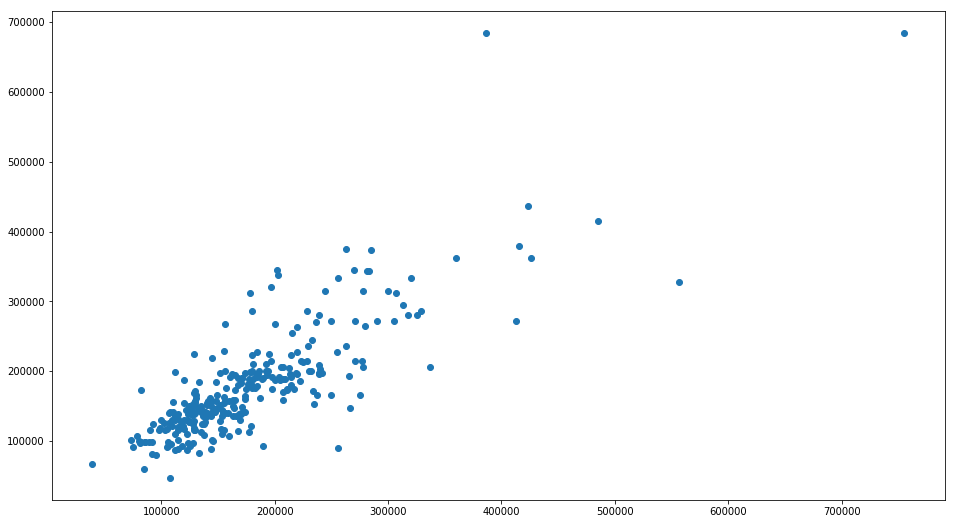

In [276]:
plt.scatter(Y_test, predictions)

# Ensembles
<img src="./media/forest.jpg">

## Bagging - independent learners
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

## Boosting - sequential learners, each one learns from previous mistakes
https://xgboost.readthedocs.io/en/latest/

# Gradient Boosting

Best ever explanation of gradient boosting https://explained.ai/gradient-boosting  

TL;DR http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

<img src="./media/boosting.png">

In [421]:
df_simple = df[['YrSold', 'YearBuilt', 'SalePrice']].head(n=10).copy()
X = df_simple.drop('SalePrice', axis='columns').values
Y = df_simple.SalePrice.values

In [422]:
df_simple

,YrSold,YearBuilt,SalePrice
0,2008,2003,208500
1,2007,1976,181500
2,2008,2001,223500
3,2006,1915,140000
4,2008,2000,250000
5,2009,1993,143000
6,2007,2004,307000
7,2009,1973,200000
8,2008,1931,129900
9,2008,1939,118000


## 1. Fit a model - F(x)

In [423]:
ensemble = []

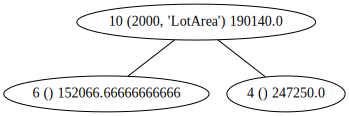

In [424]:
ensemble.append(create_tree(X, Y, np.arange(X.shape[0]), max_depth=1, col_proc=1))
plot_tree(ensemble[-1])

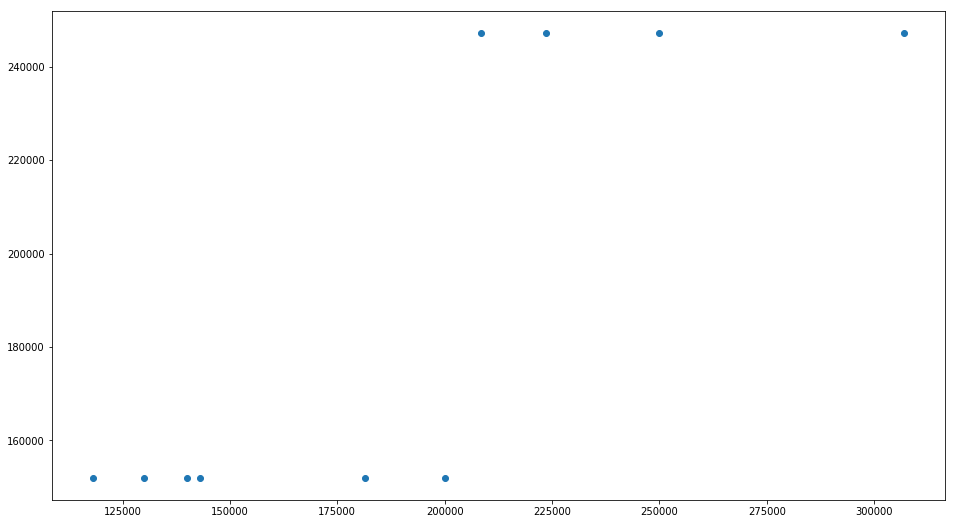

In [439]:
plt.scatter(Y, [predict_tree(ensemble[0], sample) for sample in X])

## Compute residuals

In [425]:
predictions = np.array([predict_tree(ensemble[-1], sample) for sample in X])
df_simple['p1'] = predictions
df_simple['r1'] = Y - predictions
df_simple

,YrSold,YearBuilt,SalePrice,p1,r1
0,2008,2003,208500,247250.000000,-38750.000000
1,2007,1976,181500,152066.666667,29433.333333
2,2008,2001,223500,247250.000000,-23750.000000
3,2006,1915,140000,152066.666667,-12066.666667
4,2008,2000,250000,247250.000000,2750.000000
5,2009,1993,143000,152066.666667,-9066.666667
6,2007,2004,307000,247250.000000,59750.000000
7,2009,1973,200000,152066.666667,47933.333333
8,2008,1931,129900,152066.666667,-22166.666667
9,2008,1939,118000,152066.666667,-34066.666667


In [426]:
mean_squared_error(Y, predictions), mean_squared_log_error(Y, predictions)

(1068688333.3333334, 0.029237410094233335)

## Fit more learner on residuals - h(x)

<img src="./media/boosted_stumps.gif">

In [427]:
next_learner = 2

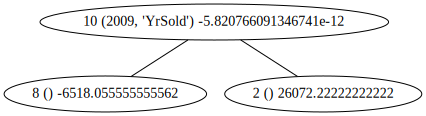

In [432]:
ensemble.append(create_tree(X, df_simple[f'r{next_learner - 1}'].values, np.arange(X.shape[0]), max_depth=1, col_proc=1))
plot_tree(ensemble[-1])

In [433]:
predictions = np.zeros(len(Y))
for t in ensemble:
    predictions += [predict_tree(t, sample) for sample in X]
df_simple[f'p{next_learner}'] = predictions
df_simple[f'r{next_learner}'] = Y - predictions
df_simple

,YrSold,YearBuilt,SalePrice,p1,r1,p2,r2,p3,r3
0,2008,2003,208500,247250.000000,-38750.000000,240611.111111,-32111.111111,234093.055556,-25593.055556
1,2007,1976,181500,152066.666667,29433.333333,145427.777778,36072.222222,138909.722222,42590.277778
2,2008,2001,223500,247250.000000,-23750.000000,240611.111111,-17111.111111,234093.055556,-10593.055556
3,2006,1915,140000,152066.666667,-12066.666667,145427.777778,-5427.777778,138909.722222,1090.277778
4,2008,2000,250000,247250.000000,2750.000000,240611.111111,9388.888889,234093.055556,15906.944444
5,2009,1993,143000,152066.666667,-9066.666667,145427.777778,-2427.777778,171500.000000,-28500.000000
6,2007,2004,307000,247250.000000,59750.000000,307000.000000,0.000000,300481.944444,6518.055556
7,2009,1973,200000,152066.666667,47933.333333,145427.777778,54572.222222,171500.000000,28500.000000
8,2008,1931,129900,152066.666667,-22166.666667,145427.777778,-15527.777778,138909.722222,-9009.722222
9,2008,1939,118000,152066.666667,-34066.666667,145427.777778,-27427.777778,138909.722222,-20909.722222


In [434]:
mean_squared_error(Y, predictions), mean_squared_log_error(Y, predictions)

(502074529.3209877, 0.017968490219020167)

In [435]:
next_learner += 1

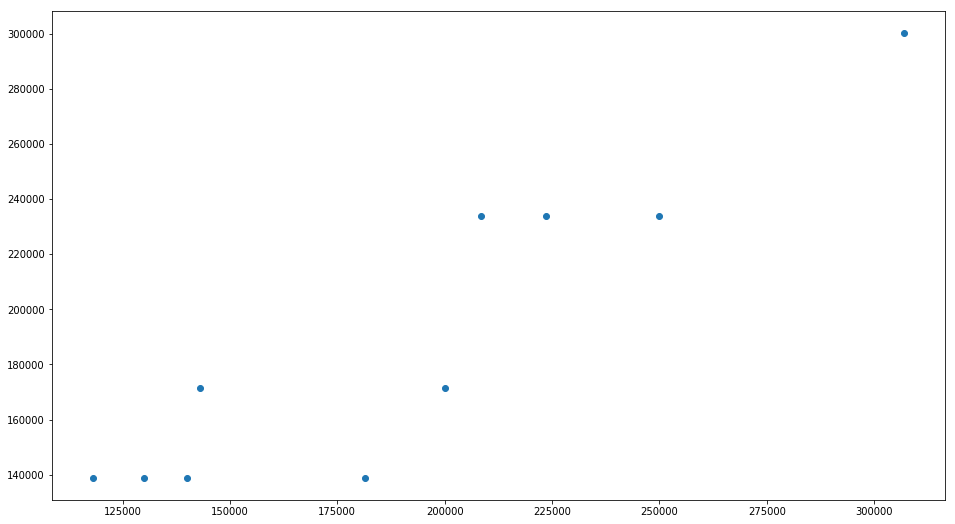

In [441]:
plt.scatter(Y, predictions)

You always fit the next learner on **y - y_predicted**  
You can start with any weak learner F(x) - for example the mean  
Then, incrementally, every **step** helps you get in the **right direction**.

## Does it remind you of Gradient Descent?
<img src="./media/matterhorn.jpg">

F(x) + h1(x) + ... + hn(X)

### Minimize a loss

\begin{align}
\text{MSE}: L(y, \text{y_pred}) = \frac{1}{N} * \sum{(\text{y} - \text{y_pred})^2}
\end{align}

Gradient shows us 2 things:
- the direction in which the function increases (we want to go down, so we invert the sign)
- the steepness of the slope

<img src="./media/grad2d.gif">

\begin{align}
\text{Gradient descent}: x_{i} = x_{i-1} - \eta * \nabla f(x_{i - 1})
\end{align}

\begin{align}
\text{Gradient of L}: \nabla L(y, \text{y_pred}) = -2(y - \text{y_pred}) \\
\end{align}

\begin{align}
\text{Gradient boosting}: F_i(x) = F_{i-1}(x) + \eta * \nabla_m(x)
\end{align}

\begin{align}
\text{Model}: F(x) + \eta * h_1(x_1) + \eta * h_2(x_2) * ... * \eta * h_n(x_n)
\end{align}

<img src="./media/golf-MSE.png">

For catching up on math: https://explained.ai/matrix-calculus/index.html

# XGBoost - Extreme?
https://arxiv.org/pdf/1603.02754.pdf
- regularization
- scalability
- 10 times faster
- lots of optimizations, caching
- runs on GPU

# Real life comparison

```
+-------------+------------------+--------------------+
|  4,865,545  |  Predicted YES   |    Predicted NO    |
|   xgb:w-c   |                  |                    |
+=============+==================+====================+
| Actual YES  | 83.43% (948,394) |  16.57% (188,356)  |
|  (23.36%)   |                  |        (fn)        |
+-------------+------------------+--------------------+
|  Actual NO  |  0.68% (25,413)  | 99.32% (3,702,623) |
|  (76.62%)   |       (fp)       |                    |
+-------------+------------------+--------------------+

+-------------+------------------+--------------------+
|  4,864,131  |  Predicted YES   |    Predicted NO    |
|   rf:w-c    |                  |                    |
+=============+==================+====================+
| Actual YES  | 86.48% (979,967) |  13.52% (153,217)  |
|  (23.30%)   |                  |        (fn)        |
+-------------+------------------+--------------------+
|  Actual NO  |  0.75% (27,893)  | 99.25% (3,697,473) |
|  (76.59%)   |       (fp)       |                    |
+-------------+------------------+--------------------+

+-------------+------------------+--------------------+
|  4,862,386  |  Predicted YES   |    Predicted NO    |
|  ultra:w-c  |                  |                    |
+=============+==================+====================+
| Actual YES  | 78.33% (889,761) |  21.67% (246,099)  |
|  (23.36%)   |                  |        (fn)        |
+-------------+------------------+--------------------+
|  Actual NO  |  1.01% (37,488)  | 98.99% (3,688,280) |
|  (76.62%)   |       (fp)       |                    |
+-------------+------------------+--------------------+
```